In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

* [Medium: Collaborative Filtering based Recommendation Systems exemplified..](https://towardsdatascience.com/collaborative-filtering-based-recommendation-systems-exemplified-ecbffe1c20b1)
* This notebook is a fork of: [CF Recommendation System-Examples.ipynb](https://github.com/csaluja/JupyterNotebooks-Medium/blob/master/CF%20Recommendation%20System-Examples.ipynb)

# Collaborative filtering based recommendation systems examples

Make necesarry imports

In [2]:
import sys
sys.path.append('./src')

from IPython.display import Image

from scipy.spatial.distance import correlation, cosine

from ratings_matrix import RatingsMatrix

from similarity import cosine_sim, \
                       pearson_sim, \
                       adjusted_cosine_sim, \
                       spearman_sim, \
                       k_similar_rows, \
                       k_similar_rows_using_adjusted_cosine

from recommendation import create_predictors, \
                           predict, \
                           evaluate, \
                           item_based_rating_predict, \
                           item_based_adjcos_rating_predict, \
                           user_based_rating_predict

from show import show_similar_items, \
                 show_similar_users, \
                 show_prediction

## Rating Matrix

* Ratings matrix is user-item ratings matrix where ratings are integers from 1-10.
* 6 users (rows) have rated 6 items (columns).

In [3]:
rm = RatingsMatrix([
    [3, 7, 4, 9,  9, 7], 
    [7, 0, 5, 3,  8, 8],
    [7, 5, 5, 0,  8, 4],
    [5, 6, 8, 5,  9, 8],
    [5, 8, 8, 8, 10, 9],
    [7, 7, 0, 4,  7, 8]
])
rm

,0,1,2,3,4,5
0,3,7,4,9,9,7
1,7,0,5,3,8,8
2,7,5,5,0,8,4
3,5,6,8,5,9,8
4,5,8,8,8,10,9
5,7,7,0,4,7,8


User ratings / row values:

In [4]:
rm.row(1)

array([[3, 7, 4, 9, 9, 7]])

Mean user rating / row mean:

In [5]:
rm.mean_row(1)

6.5

User(row) rating deviation:

In [6]:
rm.row_deviation(1, 1)

-3.5

User(Row)-item(Column) rating:

In [7]:
rm.cell(3, 4)

0

Iterate each matrix value(rating):

In [8]:
rm.for_each(lambda r, user_id, item_id: print(f'rating: {r}, user_id: {user_id}, item_id: {item_id}'))

rating: 3, user_id: 1, item_id: 1
rating: 7, user_id: 1, item_id: 2
rating: 4, user_id: 1, item_id: 3
rating: 9, user_id: 1, item_id: 4
rating: 9, user_id: 1, item_id: 5
rating: 7, user_id: 1, item_id: 6
rating: 7, user_id: 2, item_id: 1
rating: 0, user_id: 2, item_id: 2
rating: 5, user_id: 2, item_id: 3
rating: 3, user_id: 2, item_id: 4
rating: 8, user_id: 2, item_id: 5
rating: 8, user_id: 2, item_id: 6
rating: 7, user_id: 3, item_id: 1
rating: 5, user_id: 3, item_id: 2
rating: 5, user_id: 3, item_id: 3
rating: 0, user_id: 3, item_id: 4
rating: 8, user_id: 3, item_id: 5
rating: 4, user_id: 3, item_id: 6
rating: 5, user_id: 4, item_id: 1
rating: 6, user_id: 4, item_id: 2
rating: 8, user_id: 4, item_id: 3
rating: 5, user_id: 4, item_id: 4
rating: 9, user_id: 4, item_id: 5
rating: 8, user_id: 4, item_id: 6
rating: 5, user_id: 5, item_id: 1
rating: 8, user_id: 5, item_id: 2
rating: 8, user_id: 5, item_id: 3
rating: 8, user_id: 5, item_id: 4
rating: 10, user_id: 5, item_id: 5
rating: 9, us

## See similarity values

In [9]:
cosine_sim(rm)

,0,1,2,3,4,5
0,1.000000,0.799268,0.779227,0.934622,0.973890,0.884600
1,0.799268,1.000000,0.874744,0.905850,0.866146,0.827036
2,0.779227,0.874744,1.000000,0.909513,0.865454,0.853275
3,0.934622,0.905850,0.909513,1.000000,0.989344,0.865614
4,0.973890,0.866146,0.865454,0.989344,1.000000,0.881640
5,0.884600,0.827036,0.853275,0.865614,0.881640,1.000000


In [10]:
adjusted_cosine_sim(rm)

,0,1,2,3,4,5
0,1.000000,0.236908,0.421263,-0.519085,-0.125892,0.010090
1,0.236908,1.000000,-0.805243,0.085741,0.237273,0.520625
2,0.421263,-0.805243,1.000000,-0.767941,-0.230521,-0.053640
3,-0.519085,0.085741,-0.767941,1.000000,-0.299059,-0.644550
4,-0.125892,0.237273,-0.230521,-0.299059,1.000000,0.599158
5,0.010090,0.520625,-0.053640,-0.644550,0.599158,1.000000


In [11]:
pearson_sim(rm)

,0,1,2,3,4,5
0,1.000000,-0.137446,-0.357398,0.208179,0.761905,0.277350
1,-0.137446,1.000000,0.453897,0.515910,0.112456,0.218328
2,-0.357398,0.453897,1.000000,0.451378,-0.042888,0.297373
3,0.208179,0.515910,0.451378,1.000000,0.763325,-0.057739
4,0.761905,0.112456,-0.042888,0.763325,1.000000,0.039621
5,0.277350,0.218328,0.297373,-0.057739,0.039621,1.000000


In [12]:
spearman_sim(rm)

,0,1,2,3,4,5
0,2.000000,1.029854,0.776094,1.272727,1.687836,1.031265
1,1.029854,2.000000,1.382353,1.582154,1.554437,1.523635
2,0.776094,1.382353,2.000000,1.403030,1.092406,1.123208
3,1.272727,1.582154,1.403030,2.000000,1.844162,1.187592
4,1.687836,1.554437,1.092406,1.844162,2.000000,1.354839
5,1.031265,1.523635,1.123208,1.187592,1.354839,2.000000


**Note**: spearman is the robust alternative to pearson.

## User-based

In [13]:
n_neighbors = 4

### Similar users

**k_similar_rows** function finds k similar users given the user_id and ratings matrix.

Using cosine similarity:

In [14]:
user_id = 1

similarities, indices = k_similar_rows(rm, user_id, cosine, n_neighbors)

show_similar_users(indices, similarities, user_id, n_neighbors)

4 most similar users to user 1:

- User ID 5, with similarity of 0.026110064598160565.
- User ID 4, with similarity of 0.06537831582162312.
- User ID 6, with similarity of 0.11539954277021858.
- User ID 2, with similarity of 0.20073202194758122.


Using pearson similarity:

In [15]:
similarities, indices = k_similar_rows(rm, user_id, correlation, n_neighbors)

show_similar_users(indices, similarities, user_id, n_neighbors)

4 most similar users to user 1:

- User ID 5, with similarity of 0.23809523809523814.
- User ID 6, with similarity of 0.7226499018873854.
- User ID 4, with similarity of 0.7918205490733486.
- User ID 2, with similarity of 1.1374463205132774.


### user_based_rating_predict

This function predicts rating for specified user-item combination based on user-based approach:

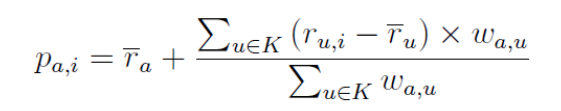

In [16]:
Image(filename='./images/user-based-similarity.png')

In [17]:
user_id = 3
item_id = 4

prediction = user_based_rating_predict(rm, user_id, item_id, cosine, n_neighbors)

show_prediction(rm, user_id, item_id, prediction)

Item base rating prediction:
- User ID: 3.
- Item ID: 4.
- Predicted rating: 3.51.
- Real rating: 0 (0 == unrated item).


## Item-based

### Similar items (Cosine sim)

**k_similar_rows** function finds k similar items given the item_id and a transposed version of ratings matrix.

In [18]:
item_id = 3

similarities, indices = k_similar_rows(rm.T(), item_id, cosine, n_neighbors)

show_similar_items(indices, similarities, item_id, n_neighbors)

4 most similar items to item 3:

- Item ID 5, with similarity of 0.08166387446547818.
- Item ID 6, with similarity of 0.12524022696180503.
- Item ID 1, with similarity of 0.18963525377782653.
- Item ID 4, with similarity of 0.20308219969760688.


### Item based predict

**item_based_rating_predict** function predicts the rating for specified user-item combination based on item-based approach:

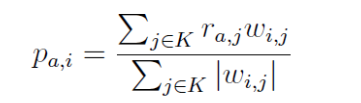

In [19]:
Image(filename='./images/item-based-similarity.png') 

In [20]:
user_id = 1
item_id = 3

prediction = item_based_rating_predict(rm, user_id, item_id, cosine, n_neighbors)

show_prediction(rm, user_id, item_id, prediction)

Item base rating prediction:
- User ID: 1.
- Item ID: 3.
- Predicted rating: 6.68.
- Real rating: 4 (0 == unrated item).


### Similar items (Adjusted cosine sim)

**k_similar_row_adjcos** function finds k similar items given the item_id and ratings matrix.

In [21]:
similarities, indices = k_similar_rows_using_adjusted_cosine(rm, 3, n_neighbors)

print(similarities)
print(indices)

[ 0.42126273 -0.05363989 -0.23052136 -0.76794105]
Int64Index([0, 5, 4, 3], dtype='int64')


### Item based prediction using adjusted cosine similarity

**item_based_adjcos_rating_predict** function predicts the rating for specified user-item combination for adjusted cosine item-based approach. As the adjusted cosine similarities range from -1,+1, sometimes the predicted rating can be negative or greater than max value. Hack to deal with this: Rating is set to min if prediction is negative, Rating is set to max if prediction is above max.

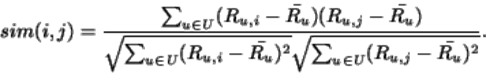

In [22]:
Image(filename='./images/adj-cos-sim.png')

In [23]:
user_id = 3
item_id = 4

prediction = item_based_adjcos_rating_predict(rm, user_id, item_id, n_neighbors)

show_prediction(rm, user_id, item_id, prediction)

Item base rating prediction:
- User ID: 3.
- Item ID: 4.
- Predicted rating: 5.94.
- Real rating: 0 (0 == unrated item).


## Predict and evaluate

In [24]:
predictors = create_predictors(rm, n_neighbors)

predict(predictors, user_id=3,  item_id=4)

{'user_based_with_minkowski': 4.4,
 'user_based_with_euclidean': 4.4,
 'user_based_with_cosine': 3.51,
 'user_based_with_pearson': 3.69,
 'user_based_with_spearman': 3.08,
 'user_based_with_manhattan': 4.38,
 'item_based_with_minkowski': 5.69,
 'item_based_with_euclidean': 5.69,
 'item_based_with_manhattan': 5.64,
 'item_based_with_cosine': 5.48,
 'item_based_with_adj_cosine': 5.94,
 'item_based_with_pearson': 5.33,
 'item_based_with_spearman': 5.95}

In [25]:
rm.cell(3, 4)

0

if the item is already rated, it is not recommended:

In [26]:
predict(predictors, user_id=2,  item_id=1)

{'user_based_with_minkowski': 4.54,
 'user_based_with_euclidean': 4.54,
 'user_based_with_cosine': 5.08,
 'user_based_with_pearson': 4.72,
 'user_based_with_spearman': 4.62,
 'user_based_with_manhattan': 4.36,
 'item_based_with_minkowski': 5.11,
 'item_based_with_euclidean': 5.11,
 'item_based_with_manhattan': 5.21,
 'item_based_with_cosine': 3.92,
 'item_based_with_adj_cosine': 2.18,
 'item_based_with_pearson': 5.22,
 'item_based_with_spearman': 4.95}

In [27]:
rm.cell(2, 1)

7

Evaluate predictions using RMSE and MAE error metrics:

In [28]:
evaluate(predictors, rm)

{'user_based_with_minkowski': {'rmse': 2.734, 'mse': 7.476},
 'user_based_with_euclidean': {'rmse': 2.734, 'mse': 7.476},
 'user_based_with_cosine': {'rmse': 2.843, 'mse': 8.085},
 'user_based_with_pearson': {'rmse': 2.774, 'mse': 7.693},
 'user_based_with_spearman': {'rmse': 2.763, 'mse': 7.636},
 'user_based_with_manhattan': {'rmse': 2.689, 'mse': 7.232},
 'item_based_with_minkowski': {'rmse': 2.554, 'mse': 6.52},
 'item_based_with_euclidean': {'rmse': 2.554, 'mse': 6.52},
 'item_based_with_manhattan': {'rmse': 2.672, 'mse': 7.141},
 'item_based_with_cosine': {'rmse': 2.618, 'mse': 6.852},
 'item_based_with_adj_cosine': {'rmse': 3.124, 'mse': 9.762},
 'item_based_with_pearson': {'rmse': 2.858, 'mse': 8.166},
 'item_based_with_spearman': {'rmse': 3.034, 'mse': 9.205}}